In [143]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [144]:
import csv
path = 'USDCAD-20yrs from Apr 19-2017-All.csv'
data = pd.read_csv(path)
data.head()
len(data)


4979

In [145]:
def loadData(data, seq):
    features = len(data.columns)
    data = data.as_matrix()
    seq_len = seq + 1
    result = []
    for i in range(len(data) - seq_len):
        result.append(data[i: i + seq_len])
    result = np.array(result)
    print(int(0.9 * len(result)))
    row = int(0.9 * len(result))
    tr = result[:row, :]
    X_tr = tr[:, :-1]
    Y_tr = tr[:, -1][:,-1]
    X_te = result[row:, :-1]
    Y_te = result[row:, -1][:,-1]
    Y = result[:, -1][:, -1]
    feat0 = Y_tr.shape[0]
    #feat1 = Y_te.shape[1]
    
    feat1 = len(Y) - feat0
    #Y_te = np.reshape(Y_te, (feat1, 1))
    #Y_tr = np.reshape(Y_tr, (feat0, 1))
    
    return X_tr, Y_tr, X_te, Y_te, Y



In [146]:

X_tr, Y_tr, X_te, Y_te, Y_to = loadData(data, 22)

4460


In [147]:
X_tr.shape, Y_tr.shape, X_te.shape, Y_te.shape, Y_to.shape

((4460, 22, 3), (4460,), (496, 22, 3), (496,), (4956,))

In [180]:
def stats(X_batch, Y_batch):
    total_loss = 0
    total_acc = 0
    samples = len(X_batch)
    #X_batch = np.reshape(X_batch, [-1, n_steps, n_inputs])
    sess = tf.get_default_session()
    for offset in range(0, samples, batch_size):
        end = offset+batch_size
        xs_batch, ys_batch = X_batch[offset:end], Y_batch[offset:end]
        loss_, acc = sess.run([loss, accuracy], feed_dict={x:xs_batch, 
                                                           y:ys_batch,
                                                           keep_prob:1.0
                                                           })
        total_loss += (float(loss_)*xs_batch.shape[0])
        total_acc += (float(acc)*xs_batch.shape[0])

    return (total_loss)/samples, (total_acc)/samples

In [189]:
def RNN(data, w, b):
    data = tf.transpose(data, [1, 0, 2])
    data = tf.reshape(data, [-1, n_inputs])
    hidden = tf.matmul(data, w['hidden']) + b['hidden']
    hidden = tf.nn.relu(hidden)
    
    hidden = tf.layers.batch_normalization(hidden)
    hidden = tf.split(hidden, n_steps, 0)
    
    rnn_layers = [tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.GRUCell(n_hidden),
                                                output_keep_prob=keep_prob) for _ in range(3)]
    rnn_layers = tf.contrib.rnn.MultiRNNCell(rnn_layers)
    out, _ = tf.contrib.rnn.static_rnn(rnn_layers, hidden, dtype=tf.float32)
    rnn_layers_output = out[-1]
    return tf.matmul(rnn_layers_output, w['out']) + b['out']
    

In [196]:
tf.reset_default_graph()
from sklearn.model_selection import train_test_split
X_tr, X_val, Y_tr, Y_val = train_test_split(X_tr, Y_tr, test_size = 0.1, random_state=0)

In [197]:
n_hidden = 128
n_steps = 22
n_inputs = 3
n_classes = len(set(Y_to))
learning_rate = 10e-4
epochs = 1000
batch_size = 128


w = {'hidden':tf.Variable(tf.random_normal([n_inputs, n_hidden])),
     'out'   :tf.Variable(tf.random_normal([n_hidden, n_classes]))
    
}
b = {'hidden':tf.Variable(tf.random_normal([n_hidden])),
     'out'   :tf.Variable(tf.random_normal([n_classes]))
    
}

x = tf.placeholder(dtype=tf.float32, shape=(None, n_steps, n_inputs))
y = tf.placeholder(dtype=tf.int32, shape=(None))
y_hot = tf.one_hot(y, n_classes) 
keep_prob = tf.placeholder(tf.float32)
print(x, y)


Tensor("Placeholder:0", shape=(?, 22, 3), dtype=float32) Tensor("Placeholder_1:0", dtype=int32)


In [198]:
logits = RNN(x, w, b)
softmax = tf.nn.softmax(logits)
step = tf.Variable(0, trainable=False)

In [199]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_hot))
optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.99).minimize(loss, global_step=step)

In [200]:
prediction = tf.equal(tf.argmax(softmax, 1), tf.argmax(y_hot, 1))
accuracy = tf.reduce_mean(tf.cast(prediction, dtype=tf.float32))

Initializing Training
EPOCH 1
Validation Loss = 1.256 and Validation Accuracy = 87.764 %
EPOCH 2
Validation Loss = 0.152 and Validation Accuracy = 89.451 %
EPOCH 3
Validation Loss = 0.087 and Validation Accuracy = 96.624 %
EPOCH 4
Validation Loss = 0.126 and Validation Accuracy = 94.093 %
EPOCH 5
Validation Loss = 0.176 and Validation Accuracy = 92.827 %
EPOCH 6
Validation Loss = 0.297 and Validation Accuracy = 89.030 %
EPOCH 7
Validation Loss = 0.081 and Validation Accuracy = 96.203 %
EPOCH 8
Validation Loss = 0.145 and Validation Accuracy = 93.671 %
EPOCH 9
Validation Loss = 0.078 and Validation Accuracy = 98.312 %
EPOCH 10
Validation Loss = 0.083 and Validation Accuracy = 97.890 %
EPOCH 11
Validation Loss = 0.165 and Validation Accuracy = 94.093 %
EPOCH 12
Validation Loss = 0.162 and Validation Accuracy = 93.249 %
EPOCH 13
Validation Loss = 0.341 and Validation Accuracy = 89.030 %
EPOCH 14
Validation Loss = 0.129 and Validation Accuracy = 94.093 %
EPOCH 15
Validation Loss = 0.153 an

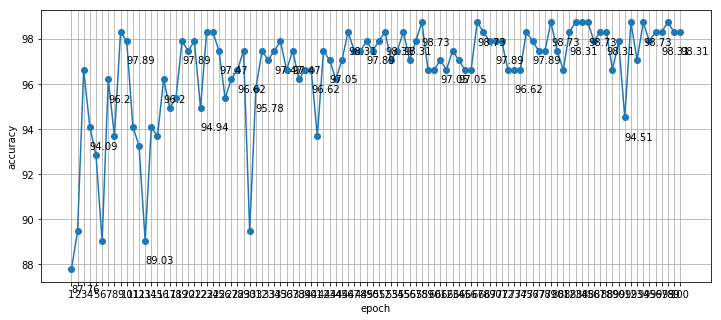

In [201]:
acc_map = []

from sklearn.utils import shuffle

epochs = 100
samples = len(X_tr)

count = 0
print("Initializing Training")
try:
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        for epoch in range(epochs):
            X_tr, Y_tr = shuffle(X_tr, Y_tr)
            for offset in range(0, samples, batch_size):
                end = offset+batch_size
                xs_batch, ys_batch = X_tr[offset:end], Y_tr[offset:end]
                loss_, _ = sess.run([loss, optimizer], feed_dict={x: xs_batch, 
                                                                  y: ys_batch,
                                                                  keep_prob:0.75})    

            validation_loss, validation_acc = stats(X_val, Y_val)
            acc_map.append(round(validation_acc*100, 2))
            print("EPOCH {}".format(epoch + 1))
            print ("Validation Loss = {:.3f} and Validation Accuracy = {:.3f} %".format(validation_loss, 100 *validation_acc))
        plt.figure(figsize=(12, 5))
        plt.xticks(range(1, epochs+1))
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.grid(True)
        plt.plot(range(1, epochs+1), acc_map, '-o')
        for i, j in list(zip(range(1, epochs+1), acc_map))[0::3]:
            plt.text(i, j-1, str(j))
        test_loss, test_acc = sess.run([loss, accuracy], feed_dict={x: xs_batch, 
                                                                    y: ys_batch,
                                                                    keep_prob:1.0})  
        print ("Test Loss {} and Test Accuracy {:.3f} %".format(test_loss, 100 *test_acc))
except KeyboardInterrupt:
    print('Training interrupted')